#### *** Adjust the path parameter to user local catalog location.***

In [1]:
# Local directory path for the galaxy zoo 2 catalog
dir_cat = "/home/hhg/Research/galaxyClassify/catalog/galaxyZoo/zoo2/"

## ------------ start ------------

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

In [3]:
df = pd.read_csv(dir_cat+'gz2_all_v2.csv')
df

,galaxyID,label_8,label_7,label_3
0,110939,0,0,0
1,187749,0,0,0
2,162781,0,0,0
3,154143,0,0,0
4,12450,0,0,0
...,...,...,...,...
155946,260790,7,6,2
155947,250189,7,6,2
155948,115591,7,6,2
155949,271627,7,6,2


In [4]:
df.groupby(['label_8']).size()

label_8
0    33898
1    39200
2     7414
3    16349
4    20407
5    30657
6     5925
7     2101
dtype: int64

## data_split

In [5]:
file_csv = dir_cat+'gz2_all_v2.csv'
f_train = 0.64
f_valid = 0.16
f_test  = 0.20
seed = 3

In [6]:
# import sys
# sys.path.append('../galaxyZooNet/')
# from datasets import data_split

import pandas as pd
from sklearn.model_selection import train_test_split

def data_split(file_csv, f_train=0.64, f_valid=0.16, f_test=0.20, random_state=None, stats=False, label_tag='label_8'):
    '''train-valid-test splits
        Args:
            file_csv (str) : path to the full catalog csv file
            f_train, f_valid, f_test : fractions of training, validation, test samples
            stats (bool): display splitting statistics if True 
        Returns:
            df_train (pd.dataframes) : splitted training sample
            df_valid (pd.dataframes) :          validation
            df_test  (pd.dataframes) :          test
    '''
    assert f_train + f_valid + f_test == 1, 'fractions have to sum to 1.'

    df = pd.read_csv(file_csv)

    df_train, df_temp = train_test_split(df, train_size=f_train, random_state=random_state)
    relative_f_valid = f_valid/(f_valid+f_test)
    df_valid, df_test = train_test_split(df_temp, train_size=relative_f_valid, random_state=random_state)
    
    if stats:
        df_stats=df.groupby([label_tag])[label_tag].agg('count').to_frame('count').reset_index()
        df_stats['full'] = df_stats['count']/df_stats['count'].sum()
        df_stats['train'] = df_train.groupby([label_tag]).size()/df_train.groupby([label_tag]).size().sum()
        df_stats['valid'] = df_valid.groupby([label_tag]).size()/df_valid.groupby([label_tag]).size().sum()
        df_stats['test'] = df_test.groupby([label_tag]).size()/df_test.groupby([label_tag]).size().sum()
        
        ax = df_stats.plot.bar(x=label_tag, y=['full', 'train', 'valid', 'test'], rot=0)
        ax.set_ylabel('class fraction')
    
    return df_train.reset_index(drop=True), df_valid.reset_index(drop=True), df_test.reset_index(drop=True)


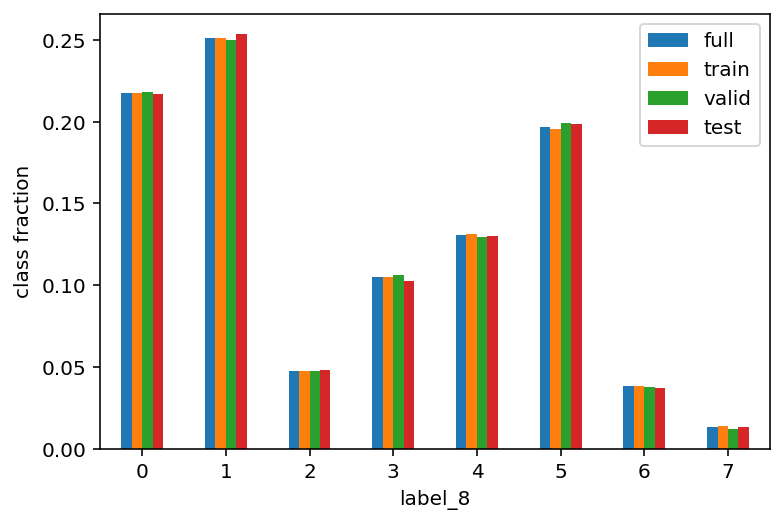

In [7]:
df_train, df_valid, df_test = data_split(file_csv, f_train, f_valid, f_test, random_state=seed, stats=True)

In [8]:
df_train

,galaxyID,label_8,label_7,label_3
0,30243,0,0,0
1,261919,5,5,1
2,158898,4,4,1
3,203726,0,0,0
4,24814,1,1,0
...,...,...,...,...
99803,18638,0,0,0
99804,82075,4,4,1
99805,56781,1,1,0
99806,174405,2,2,0


## GalaxyZooDataset

In [9]:
# import sys
# sys.path.append('../galaxyZooNet/')
# from datasets import GalaxyZooDataset

import os
from PIL import Image
from torch.utils.data import Dataset

class GalaxyZooDataset(Dataset):
    '''Galaxy Zoo 2 image dataset
        Args:
            dataframe : pd.dataframe, outputs from the data_split function
                e.g. df_train / df_valid / df_test
            dir_image : str, path where galaxy images are located
            label_tag : str, class label system to be used for training
                e.g. label_tag = 'label_8' / 'label_3'
    '''

    def __init__(self, dataframe, dir_image, label_tag='label1', transform=None):
        self.df = dataframe
        self.transform = transform
        self.dir_image = dir_image
        self.label_tag = label_tag

    
    def __getitem__(self, index):
        galaxyID = self.df.iloc[[index]].galaxyID.values[0]
        file_img = os.path.join(self.dir_image, str(galaxyID) + '.jpg')
        image = Image.open(file_img)

        if self.transform:
            image = self.transform(image)
        
        label = self.df.iloc[[index]][self.label_tag].values[0]

        return image, label

    def __len__(self):
        return len(self.df)

``dir_image`` : path to the [galaxy zoo 2 images](https://www.kaggle.com/jaimetrickz/galaxy-zoo-2-images)

In [10]:
dir_image = '/home/hhg/Research/galaxyClassify/catalog/galaxyZoo_kaggle/gz2_images/images'
dataset_train = GalaxyZooDataset(df_train, dir_image, label_tag='label_8')

In [11]:
i = 34
df_train.iloc[[i]]

,galaxyID,label_8,label_7,label_3
34,190476,6,6,2


label1 = 6


(-0.5, 423.5, 423.5, -0.5)

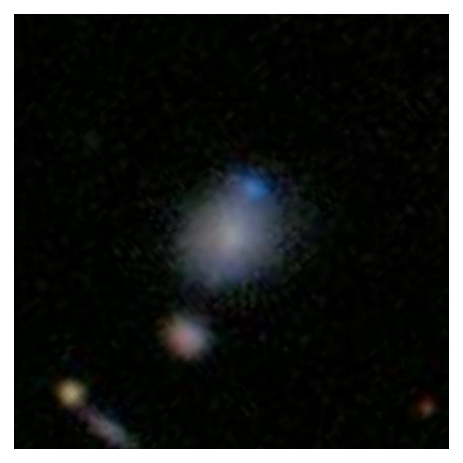

In [12]:
image_i, label_i = dataset_train[i]
print('label1 =',label_i)

fig, ax = plt.subplots()
ax.imshow(image_i)
ax.axis('off')

## dataloader

In [13]:
from torch.utils.data import DataLoader

In [14]:
import torchvision.transforms as transforms

def create_transforms():
    
    input_size = 224

    # transforms for training data
    train_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.RandomRotation(90),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomResizedCrop(input_size, scale=(0.85, 1.0), ratio=(0.9, 1.1)),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    # transforms for validation data
    valid_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.RandomRotation(90),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomResizedCrop(input_size, scale=(0.85, 1.0), ratio=(0.9, 1.1)),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])  

    # transforms for test data
    test_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    
    return train_transform, valid_transform, test_transform

In [15]:
BATCH_SIZE = 64
workers = 2 

# create transforms
train_transform, valid_transform, test_transform = create_transforms()

# create datasets
data_train = GalaxyZooDataset(df_train, dir_image, transform=train_transform, label_tag='label1')
data_valid = GalaxyZooDataset(df_valid, dir_image, transform=valid_transform, label_tag='label1')
data_test  = GalaxyZooDataset(df_test , dir_image, transform=test_transform , label_tag='label1')

# dataloaders
train_loader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=workers)
valid_loader = DataLoader(data_valid, batch_size=BATCH_SIZE, shuffle=True, num_workers=workers)
test_loader  = DataLoader(data_test , batch_size=BATCH_SIZE, shuffle=True, num_workers=workers)

# check the sizes
print(f'Number of training data: {len(data_train)} ({len(train_loader)} batches)')
print(f'Number of validation data: {len(data_valid)} ({len(valid_loader)} batches)')
print(f'Number of test data: {len(data_test)} ({len(test_loader)} batches)') 

Number of training data: 99808 (1560 batches)
Number of validation data: 24952 (390 batches)
Number of test data: 31191 (488 batches)


## ------------ compute the mean and std of the galaxy image dataset------------

In [16]:
import torch
from tqdm.notebook import tqdm
from time import time

In [17]:
basic_transform = transforms.Compose([transforms.CenterCrop(224),
                                      transforms.ToTensor()])

data_full0 = GalaxyZooDataset(df, dir_image, transform=basic_transform, label_tag='label_8')

full_loader0 = DataLoader(data_full0, batch_size=1, shuffle=True, num_workers=2)

In [18]:
n_channels = 3

before = time()
mean = torch.zeros(n_channels)
std = torch.zeros(n_channels)

print('==> Computing mean and std..')
for images, _labels in tqdm(full_loader0):
    for i in range(n_channels):
        mean[i] += images[:,i,:,:].mean()
        std[i] += images[:,i,:,:].std()


mean = mean/len(full_loader0)
std  = std /len(full_loader0)  

print('Full galaxy dataset mean :', mean)
print('Full galaxy dataset std  :', std)

==> Computing mean and std..


  0%|          | 0/155951 [00:00<?, ?it/s]

Full galaxy dataset mean : tensor([0.0940, 0.0815, 0.0630])
Full galaxy dataset std  : tensor([0.1303, 0.1100, 0.0913])
